In [166]:
#All imports
import requests
from bs4 import BeautifulSoup
import pandas as pd
import re
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from collections import Counter
dutch_stopwords = stopwords.words('dutch')
import spacy
from spacy import displacy
from spacy.pipeline import EntityRuler
nlp = spacy.load("nl_core_news_lg")

# Data Preparation

In [207]:
#Search term with amount of results specified
zoekterm = 'mensensmokkel'
aantal_resultaten = 1038

#API request with JSON specifications
specs = {"StartRow":0,"PageSize":aantal_resultaten,"ShouldReturnHighlights":True,"ShouldCountFacets":True,"SortOrder":"Relevance","SearchTerms":[{"Term":zoekterm,"Field":"AlleVelden"}],"Contentsoorten":[],"Rechtsgebieden":[],"Instanties":[],"DatumPublicatie":[],"DatumUitspraak":[],"Advanced":{"PublicatieStatus":"AlleenGepubliceerd"},"CorrelationId":"6bfa66c27937487db61d3a91e7884135","Proceduresoorten":[]}
url = 'https://uitspraken.rechtspraak.nl/api/zoek'

x = requests.post(url, json = specs)

resultaten = x.json()['Results']
lijst_case_ids = [i['TitelEmphasis'] for i in resultaten]

list_dicts = []

#For each ECLI retrieve complete tekst, ID and Date of court case
for case in lijst_case_ids:
    url = 'https://data.rechtspraak.nl/uitspraken/content?id='+ case
    document = requests.get(url)
    soup= BeautifulSoup(document.content,"lxml-xml")
    para = soup.find_all("para")
    date = soup.find("dcterms:date").text
    lijst_paras = [paragraaf.text.strip() for paragraaf in para]
    complete_string = ' '.join(lijst_paras)
    dict_document = {'ID': case, 'Text': complete_string, 'Date': date}
    list_dicts.append(dict_document)

df = pd.DataFrame(list_dicts)

In [210]:
#Loading Vehicle File to add entity ruling to NER pipeline
df_voertuigen = pd.read_excel('Voertuigen.xlsx', index_col=None, header=None) 
df_voertuigen.columns = ['type', 'label']
patterns = []
for index, row in df_voertuigen.iterrows():
    patterns.append({"label":row['label'], "pattern": [{"LEMMA":row['type']}]})

In [211]:
#Add the Ruler to the pipeline
ruler = nlp.add_pipe("entity_ruler")
ruler.add_patterns(patterns)

In [212]:
#words before entitites that are not relevant and will be skipped
voorvoegsels = ['te','locatie', 'rechtbank', 'die', '[', '.', ',', 'Onderzoek', '(', 'art.', 'gerechtshof', ':', 'advocaat', 'gemeente']

#Entities that are not relevant for this research
not_entiteiten = ['Zittingsplaats', 'Nederland', 'IJsland', 'Noorwegen' , 'New York', 'Zittinghoudende', 'Verhoorprotocol', 'hen/haar/hem', 'nevenzttingsplaats', 'Vrijheidsstraf', 'Bewijsoverwegingen', 'Wederrechtelijk']

In [213]:
#function to retrieve a possible smuggling route from court cases
def get_route(text):
    pros_text = nlp(text)

    route = []
    for index, token in enumerate(pros_text.ents): 
        if token.label_ == 'GPE' or token.label_ == 'FAC' or token.label_ == 'LOC' or token.label_ == 'NORP' or token.label_ == 'VEHICLE':
            #TODO: kiezen of bepaalde entiteiten weggelaten moeten worden
            if token.text not in not_entiteiten:
                span = pros_text.ents[index]
                if pros_text[span.start - 1].text not in voorvoegsels and (pros_text[span.start - 1].text,token.text) not in route:
                    route.append((pros_text[span.start - 1].text,token.text))

    final_route = " ".join([i for sub in route for i in sub])
    
    if not final_route:
        final_route = "Geen route beschikbaar in document"
    return final_route

In [214]:
#Get all the important info from uitspraak and put into column 'Route'
df['Route'] = df.apply(lambda row : get_route(row['Text']), axis=1)

In [236]:
#function to only retrieve distinct vehicles per court case
def get_vehicles(text):
    pros_text = nlp(text)

    route = []
    for token in pros_text.ents: 
        if token.label_ == 'VEHICLE':
            token = token.lemma_
            if token not in route:
                route.append(token)
    final_route = ";".join([i for i in route])
    return final_route

In [237]:
#Apply the function to the court cases
df['Vehicles'] = df.apply(lambda row : get_vehicles(row['Text']), axis=1)

# Similarity, Clustering and Plotting


In [11]:
import jellyfish

In [12]:
#Create the similarity scores for each document
ct = pd.DataFrame(index=df['Route'], columns=df['Route'])
ct = ct.apply(lambda col: [jellyfish.jaro_distance(col.name, x) for x in col.index])

In [13]:
#Create dataframe for all the similarity scores
sim_scores = ct.values
sim_scores_df = pd.DataFrame(data=sim_scores,index=df['ID'], columns=df['ID'])
sim_distances_df = 1- sim_scores_df

ID,ECLI:NL:GHAMS:2021:3695,ECLI:NL:RBGRO:2005:AT5556,ECLI:NL:RBROT:2018:862,ECLI:NL:RBROT:2018:865,ECLI:NL:RBNHO:2017:3359,ECLI:NL:RBLIM:2021:2309,ECLI:NL:RBLIM:2021:2062,ECLI:NL:GHAMS:2019:1303,ECLI:NL:GHAMS:2019:736,ECLI:NL:OGEAC:2018:350,...,ECLI:NL:RBZUT:2012:BX7175,ECLI:NL:RBLEE:2007:BA4735,ECLI:NL:RBNNE:2021:5240,ECLI:NL:GHAMS:2018:3417,ECLI:NL:RBOVE:2014:6932,ECLI:NL:RBOVE:2014:6949,ECLI:NL:RBOVE:2014:6944,ECLI:NL:RBZWB:2021:6411,ECLI:NL:OGHACMB:2021:197,ECLI:NL:RBLIM:2020:8097
ID,,,,,,,,,,,,,,,,,,,,,
ECLI:NL:GHAMS:2021:3695,1.000000,0.507234,0.544229,0.533684,0.550787,0.527030,0.541935,0.618042,0.566051,0.497085,...,0.546267,0.562532,0.589992,0.599583,0.605608,0.478468,0.518774,0.499734,0.578581,0.524876
ECLI:NL:RBGRO:2005:AT5556,0.507234,1.000000,0.666558,0.593798,0.604495,0.652472,0.687865,0.585192,0.591275,0.630116,...,0.678311,0.630178,0.693415,0.550810,0.562947,0.558267,0.584928,0.624544,0.570300,0.654551
ECLI:NL:RBROT:2018:862,0.544229,0.666558,1.000000,0.648041,0.638168,0.697310,0.697153,0.595631,0.633613,0.656794,...,0.597432,0.676439,0.637460,0.574919,0.623495,0.571118,0.646100,0.661085,0.618817,0.588167
ECLI:NL:RBROT:2018:865,0.533684,0.593798,0.648041,1.000000,0.656829,0.584230,0.575328,0.688358,0.698409,0.546972,...,0.520010,0.608307,0.539070,0.608293,0.685918,0.606553,0.652452,0.566346,0.607625,0.543079
ECLI:NL:RBNHO:2017:3359,0.550787,0.604495,0.638168,0.656829,1.000000,0.634328,0.595682,0.636033,0.644191,0.596124,...,0.559616,0.612041,0.583275,0.586542,0.640381,0.628037,0.655523,0.636488,0.670277,0.542764
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ECLI:NL:RBOVE:2014:6949,0.478468,0.558267,0.571118,0.606553,0.628037,0.592032,0.596460,0.545827,0.613950,0.513496,...,0.517261,0.587909,0.525741,0.553948,0.607193,1.000000,0.841689,0.580135,0.609841,0.546953
ECLI:NL:RBOVE:2014:6944,0.518774,0.584928,0.646100,0.652452,0.655523,0.620774,0.604665,0.611679,0.679136,0.567827,...,0.539397,0.626694,0.555829,0.577300,0.663100,0.841689,1.000000,0.589943,0.655336,0.564450
ECLI:NL:RBZWB:2021:6411,0.499734,0.624544,0.661085,0.566346,0.636488,0.656902,0.665950,0.546815,0.551108,0.642175,...,0.584508,0.622087,0.620494,0.518728,0.544412,0.580135,0.589943,1.000000,0.592603,0.596605


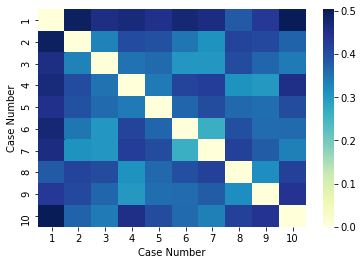

In [243]:
import seaborn as sns
%matplotlib inline

#correlation_matrix for heatmap plotting
corr = sim_distances_df[:10].iloc[:, :10].values

# plot the heatmap
s = sns.heatmap(corr, 
        xticklabels=index,
        yticklabels=cols,
               cmap = 'YlGnBu')

s.set(xlabel='Case Number', ylabel='Case Number')

fig = s.get_figure()
fig.savefig("Heatmap.png")

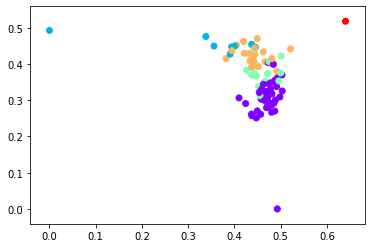

In [244]:
#Clustering off the similarity matrix
import scipy.cluster.hierarchy as spc
corr = sim_scores_df.values
pdist = spc.distance.pdist(corr)
linkage = spc.linkage(pdist, method='complete')
idx = spc.fcluster(linkage, 0.5 * pdist.max(), 'distance')
plot = plt.scatter(sim_distances_df.values[:,0],sim_distances_df.values[:,1], c=idx, cmap='rainbow')
fig = plot.get_figure()
fig.savefig("Clusters.png")

In [ ]:
#plotting the vehicles count per year in court cases
df_vehicles = df.copy()
df_vehicles = df_vehicles.drop(['Text','Route','Date'], 1)
for idx, row in df_vehicles.iterrows():
    for vehicle in row.Vehicles.split(";"):
        df.loc[idx, vehicle] = 1

df_vehicles.fillna(0, inplace=True)
df_vehicles = df_vehicles.drop('Vehicles',1)
df_vehicles_end = pd.concat([df_vehicles, df['Date']],axis=1)
df_vehicles_end['Date'] =  pd.to_datetime(df_vehicles_end['Date'])
df_vehicles_end['Year'] = df_vehicles_end['Date'].dt.year
df_vehicles_end = df_vehicles_end.drop(['ID', 'Date'], 1)
df_count_vehicles = df_vehicles_end.groupby('Year').sum()
df_count_vehicles = df_count_vehicles.drop(df_count_vehicles.tail(1).index)
df_count_vehicles = df_count_vehicles[['vrachtauto', 'trein', 'auto', 'bus', 'boot', 'vliegtuig']]
df_endresult_vehicles = df_count_vehicles.rename(columns={'vrachtauto': 'truck', 'trein': 'train', 'auto': 'car', 'bus': 'bus', 'boot': 'boat', 'vliegtuig': 'airplane'})
plot = df_endresult_vehicles.plot(y=df_endresult_vehicles.columns, use_index=True, kind='line')
plot.set(ylabel='Count')
fig = plot.get_figure()
fig.savefig("VehicleVerdeling.png")